In [1]:
import numpy as np                               # numerical operations
import pandas as pd                              # data manuplation
import torch                                     # used to build and train neural networks
import torch.nn as nn                            # contains modules and functions to build neural networks
import torch.nn.functional as F                  # provides additional functions like activation functions
import torch.optim as optim                      # Contains optimization algorithms
from sklearn.preprocessing import LabelEncoder   # convert categorical labels into numerical values
from torch.utils.data import Dataset, DataLoader # handle data loading and batching
import matplotlib.pyplot as plt                  #  plotting data
import pickle                                    # serialize and save Python objects(model and encoder)
import datetime
import os                                        # interact with the operating system

# Step-1 : Data Loading and Preparation

### [1]. Load Data

In [3]:
df = pd.read_csv('Dataset/Crop.csv')
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


### [2]. Separate Features and Labels 

In [4]:
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values

### [3]. Encode Labels

In [5]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
num_classes = len(np.unique(labels))


In [6]:
# Convert the features and labels to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)
# A tensor is a multi-dimensional array of numerical values

# Step-2 : Feature Normalization

In [7]:
# Normalize the features to have zero mean and unit variance
mean = features.mean(dim=0)
std = features.std(dim=0)
features = (features - mean) / std

In [8]:
features[0]

tensor([ 1.0686, -0.3445, -0.1017, -0.9354,  0.4726,  0.0433,  1.8099])

In [10]:
# Save the mean and standard deviation as separate arrays
np.savez("./model/normalization/normalization.npz", mean=mean, std=std)

In [11]:
with open("./model/pkl_files/encoder.pkl", "wb") as file:
    pickle.dump(encoder, file)
# The label encoder is saved for use in decoding predictions back to the original labels

# Step-3 : Dataset Preparation for PyTorch

### [1]. Custom Dataset Class

In [12]:
# Define a custom PyTorch dataset to wrap the features and labels
# necessary for loading the data in batches during training
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label
'''
For making the data compatable with PyTorch DataLoader
Once defined, CustomDataset can be passed to a DataLoader, 
which can handle the data in batches, shuffle it, and load it efficiently for training the mode
'''

'\nFor making the data compatable with PyTorch DataLoader\nOnce defined, CustomDataset can be passed to a DataLoader, \nwhich can handle the data in batches, shuffle it, and load it efficiently for training the mode\n'

### [2]. Splitting the data

In [13]:
dataset = CustomDataset(features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Step-4 : Defining Neural Network Architecture

In [14]:
# defining neural network class Net_64_128_64 with the primary goal of performing a classification task
'''
3 hidden layers
uses SELU (Scaled Exponential Linear Unit) activation function in each hidden layer
SELU -> self-normalization in each hidden layer (-inf, +inf)
Softmax function at output layer
'''
class Net_64_128_64(nn.Module):
    def __init__(self, input_size,num_classes):
        super(Net_64_128_64, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)   # 1st fc layer taking input_size features and mapping them to 64 neurons
        self.fc2 = nn.Linear(64, 128)          # 2nd fc layer with 64 i/p and 128 o/p neurons
        self.fc3 = nn.Linear(128, 64)          # 3rd fc layer with 128 i/p and 64 o/p neurons
        self.fc4 = nn.Linear(64, num_classes)  # final layer maps the 64 neurons to num_classes, producing output probabilities for each class

# x -> input (feed forwarding)
    def forward(self, x):
        x = F.selu(self.fc1(x)) # passing x through 1st layer and then applying SELU for non-linearity
        x = F.selu(self.fc2(x)) # passing o/p of 1st layer as i/p to 2nd layer "
        x = F.selu(self.fc3(x)) # " 2nd " 3rd "
        x = self.fc4(x)         # passinf through final layer without activation
        return F.softmax(x)     # applying Softmax to convert final layer's raw outputs into class probabilities


# Step-5 : Initialize Model, Loss Function, and Optimizer

In [15]:
# Define the network hyperparameters
input_size = 7   # number of features
num_classes = 22 # number of unique labels

# Initialize the network
net = Net_64_128_64(input_size, num_classes)

# Defining loss function : Measures the difference between the predicted output and the actual output
criterion = nn.CrossEntropyLoss() # for classification CRL is used and for regression MSE

# Defining optimizer : trains neural networks by adjusting the learning rate for each parameter based on its gradient history
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # worst
optimizer = optim.Adam(net.parameters(), lr=0.0001) # less traing cost for each epoch compared to SGD

# Train the network
train_losses = []
val_losses = []
EPOCH = 100
train_accuracies = []
val_accuracies = []

# Step-6 : Model Training

In [16]:
for epoch in range(EPOCH): # 1 EPOCH : one full pass through the entire dataset.
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataset): #goes through each mini-batch of data in train_dataset
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Train Loss : avg error calculated on training dataset after each epoch
    train_loss = running_loss / len(train_dataset) 
    train_losses.append(train_loss)
    
    # Validation Loss : avg error on the subset of data not used in training after each epoch
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_dataset:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_dataset)
        val_losses.append(val_loss)
    if epoch % 10 == 9:
        print(f'Epoch {epoch+1}/{EPOCH}: train loss: {train_loss:.4f} val loss: {val_loss:.4f}')

print('Finished training')


/var/folders/2j/8160v4nn7g952ngdz8d5yfvc0000gn/T/ipykernel_742/354819072.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)     # applying Softmax to convert final layer's raw outputs into class probabilities


Epoch 10/100: train loss: 2.2126 val loss: 2.2116
Epoch 20/100: train loss: 2.1887 val loss: 2.1913
Epoch 30/100: train loss: 2.1823 val loss: 2.1836
Epoch 40/100: train loss: 2.1782 val loss: 2.1819
Epoch 50/100: train loss: 2.1748 val loss: 2.1818
Epoch 60/100: train loss: 2.1728 val loss: 2.1793
Epoch 70/100: train loss: 2.1725 val loss: 2.1791
Epoch 80/100: train loss: 2.1717 val loss: 2.1783
Epoch 90/100: train loss: 2.1710 val loss: 2.1828
Epoch 100/100: train loss: 2.1705 val loss: 2.1823
Finished training


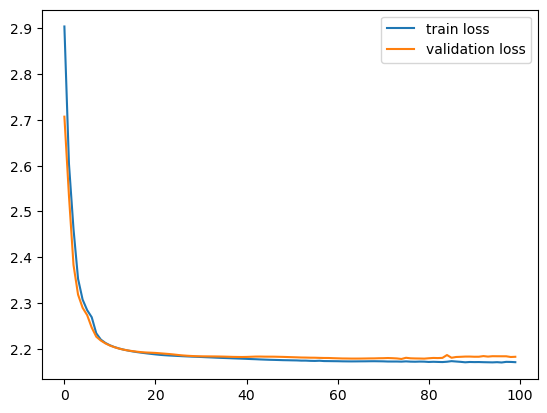

In [17]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

# Step-7 : Model Saving

In [18]:
# trained model’s parameters are saved to a file with a timestamped name
model_name = str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-') + '.hdf5'
file_name = f'./model/{model_name}'
if not os.path.exists('./model/'):
    os.mkdir('./model/')
    print("creating model dir")

In [19]:
torch.save(net.state_dict(), file_name)

In [20]:
model = Net_64_128_64(input_size,num_classes)
model.load_state_dict(torch.load('./model/baseline/baseline.hdf5'))

<All keys matched successfully>

# Step-8 : Model Evaluation

In [24]:
# Calculate the accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_dataset:
        outputs = model(inputs)
        predicted = outputs.argmax() 
        # print(predicted, labels)
        total += 1
        correct += (predicted == labels)
        # print(predicted)

accuracy = 100 * correct / total
print(f'Accuracy of the network on the train: {accuracy:.2f}%')


Accuracy of the network on the train: 99.43%


/var/folders/2j/8160v4nn7g952ngdz8d5yfvc0000gn/T/ipykernel_742/354819072.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)     # applying Softmax to convert final layer's raw outputs into class probabilities


In [26]:
# Calculate the accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_dataset:
        # print("Inputs:",inputs)
        outputs = model(inputs)
        predicted = outputs.argmax() 
        # print(predicted, labels)
        total += 1
        correct += (predicted == labels)
        # dec_labels= encoder.inverse_transform(np.array([predicted,labels]))
        # print(f"pred: {dec_labels[0]}, real: {dec_labels[1]}")
        # print(predicted)

accuracy = 100 * correct / total
print(f'Accuracy of the network on the validation: {accuracy:.2f}%')

Accuracy of the network on the validation: 99.32%


/var/folders/2j/8160v4nn7g952ngdz8d5yfvc0000gn/T/ipykernel_742/354819072.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)     # applying Softmax to convert final layer's raw outputs into class probabilities
